In [1]:
from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

import h5py

In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
from sightline import Sightline
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
import time

# import globalvars
# dust_data = globalvars.DustData()
# with h5py.File(map_fname, 'r') as f:
#     edenhofer = np.array(f['data'])
#     dust_data.intake_map(edenhofer)

In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [6]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [7]:
# sample_dim_l[0] - sample_dim_l[1]

In [8]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))

91
23
28


In [9]:
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))

In [10]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
allStar = Table.read(tabfile, hdu = 1)
print(len(allStar))
starFlag = allStar['ASPCAPFLAG']
starMask = np.invert((np.logical_and(starFlag, 2**23)==True))
allStar = allStar[starMask]
print(len(allStar))
highLat = allStar[(np.abs(allStar['GLAT']) > 15) & (1000/allStar['GAIAEDR3_PARALLAX'] < 1.5e3) & (allStar['SFD_EBV'] < 0.2)]

data_criteria_hl= (((highLat['SNR'] > 80) & (highLat['TEFF'] > 5000)) | (highLat['SNR'] > 150)) & (highLat['ASPCAP_CHI2'] > 1) & (highLat['ASPCAP_CHI2'] < 5)
print(sum(data_criteria_hl))

print(len(highLat))
highLat = highLat[data_criteria_hl]

733901
348087
45661
74255


In [11]:
133 & 2**23

0

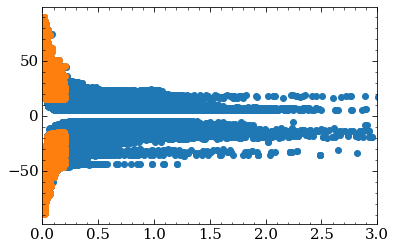

In [12]:
fig, ax = plt.subplots()
ax.scatter(allStar['SFD_EBV'], allStar['GLAT'])
ax.set_xlim(0, 3)
ax.scatter(highLat['SFD_EBV'], highLat['GLAT'])


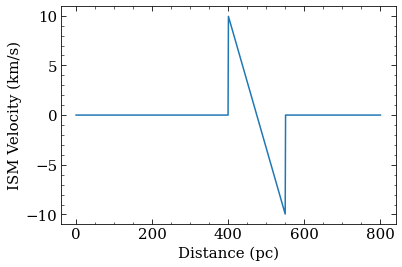

Text(0, 0.5, 'dA(V)/dd')

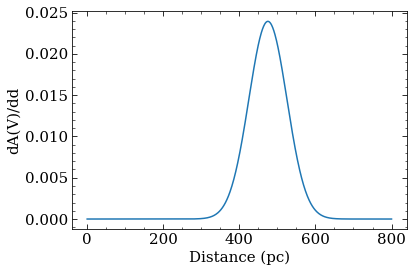

In [13]:
fig, ax = plt.subplots()
cloudmin, cloudmax = (400, 550)
nearvelo, farvelo = (+10, -10)
rvelo = (farvelo - nearvelo) / (cloudmax - cloudmin) * (dust_data.distance - cloudmin) - farvelo
rvelo[(dust_data.distance < cloudmin) | (dust_data.distance > cloudmax)] = 0
ax.plot(dust_data.distance, rvelo)
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('ISM Velocity (km/s)')
plt.show()

cloudcen = 0.5 * (cloudmin + cloudmax)
d0 = 400            # Cloud center
w0 = 50             # Cloud width (stdev)
Av_max = 3          # Maximum extinction

def differentialAV(d, d0 = cloudcen, w0 = w0, Av_Max = Av_max):
    A = Av_max / (np.sqrt(2 * np.pi) * w0) 
    return A * np.exp(-(d - d0)**2 / (2 * w0**2))

diff_AV = differentialAV(dust_data.distance)

fig, ax = plt.subplots()
ax.plot(dust_data.distance, diff_AV)
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('dA(V)/dd')

In [14]:
# from residual_process import reprocess
from spacefns_v2 import find_nearest, find_nearest_dist
from filehandling import get_medres, getASPCAP, getapStar
from residual_process import generateResidual

class InjectionSightline(Sightline):
    def __init__(self, stars, rvelo, dAVdd = None, injectRealContinuum = True, bins = None, **kwargs):
        super().__init__(stars, **kwargs)
        self.actual_DIBs = np.copy(self.signals)
        self.actual_DIB_errs = np.copy(self.signal_errs)
        self.makeSyntheticDIBs(rvelo, dAVdd = dAVdd, injectRealContinuum = injectRealContinuum)

    def makeSyntheticDIBs(self, rvelo, dAVdd = None, injectRealContinuum = True):
        continua = np.zeros(self.signals.shape)
        continua_errs = np.zeros(self.signals.shape)
        dustcolumn = np.zeros((len(self.stars), dust_data.dustmap.shape[-1]))
        for i in range(len(self.stars)):
            star = self.stars[i]
            rv_star = star['VHELIO_AVG']
            if injectRealContinuum:
                continuum, continuum_uncertainty = self.getAnalogContinuum(star, rv_star)
                continua[i, :] = continuum[window]
                continua_errs[i, :] = continuum_uncertainty[window]
            else:
                continuum = 1 + np.random.normal(scale = 1/star['SNR'], size = np.sum(window))
                continuum_uncertainty = np.ones(np.sum(window)) * 1/star['SNR']
                continua[i, :] = continuum
                continua_errs[i, :] = continuum_uncertainty

            l_i, b_i = find_nearest(star['GLON'], star['GLAT'])
            d_i = find_nearest_dist(star['DIST']).item()
            if dAVdd is not None:
                dcol = np.copy(dAVdd)
                dcol[d_i:] = 0
            else:
                dcol = dust_data.dustmap[b_i, l_i, :]
                dcol[d_i:] = 0
            dustcolumn[i, :] = dcol

                

        raw_DIB = self.integrateMockDIB(rvelo, dustcolumn)
        signals = raw_DIB - 1 + continua

        self.signals = signals
        self.signal_errs = continua_errs
        self.raw_DIB = raw_DIB
        self.continuum = continua
        self.dustcolumn = dustcolumn

    def getAnalogContinuum(self, star, rv_star, reference_stars = highLat):
            SNRdiff = np.abs(reference_stars['SNR'] - star['SNR'])
            TEFFdiff = np.abs(reference_stars['TEFF'] - star['TEFF'])
            LOGGdiff = np.abs(reference_stars['LOGG'] - star['LOGG'])
            M_Hdiff = np.abs(reference_stars['M_H'] - star['M_H'])
            starAnalogs = np.logical_and.reduce([(SNRdiff < 30), (TEFFdiff < 250), (LOGGdiff < 0.2), (M_Hdiff < 0.1)]) 
            analog_i = np.argmin(reference_stars[starAnalogs]['SFD_EBV'])
            analog = reference_stars[analog_i]
            medres = fits.open(get_medres(analog['TEFF'], analog['LOGG'], analog['M_H']))
            aspcap = fits.open(getASPCAP(analog))
            apstar = fits.open(getapStar(aspcap))
            res, res_err = generateResidual(aspcap, medres, apstar, rv_star)
            return res, res_err
            
    def integrateMockDIB(self, rvelo, dAVdd):
        print(rvelo.shape)
        print(dAVdd.shape)
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(rvelo), 1))
        print(wavs_grid.shape)
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, 1)

        def single_signal(amp, bindex):
            # amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, 0)# bin_index)
        return signals



In [15]:
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    print(len(selection))
    selected_inds.append(selection)

5
5
5
5
5
5
5
5
5
5
7
5
5
5
5
5
5
7
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
14
5
5
6
5
5
5
5
6
5
5
5
5
5
5
6


In [16]:

if False: 
    fig, ax = plt.subplots(figsize = (6,6))

    im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
    ax.set_xlabel('l (deg)')
    ax.set_ylabel('b (deg)')
        
    ax.scatter(l_sample[i], b_sample[i],  color = 'C0')


    cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

    fig.colorbar(im, ax = ax, cax = cax0, label = '$A_V$')
    xmin, xmax = ax.get_xlim()
    # ax.legend(loc = 'upper left')
    ax.set_xlim(xmax, xmin)

    plt.show()

In [17]:
sightlines = []
for i in range(10):
    indx = selected_inds[i]
    sightlines.append(InjectionSightline(CA_meta[indx], rvelo = rvelo, dAVdd = diff_AV, injectRealContinuum = True , dustdata = dust_data))
    sightlines[i].intake_coords(l_sample, b_sample, AV = AV_sample)

/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/residual_process.py:7: RuntimeWarning: invalid value encountered in true_divide
  res = hdu_rf[0, :] / hdu_rf[2, :]
/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/residual_process.py:62: RuntimeWarning: invalid value encountered in true_divide
  res_corr = spectrum / model / medres_model


(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)


In [18]:
np.array(None)

array(None, dtype=object)

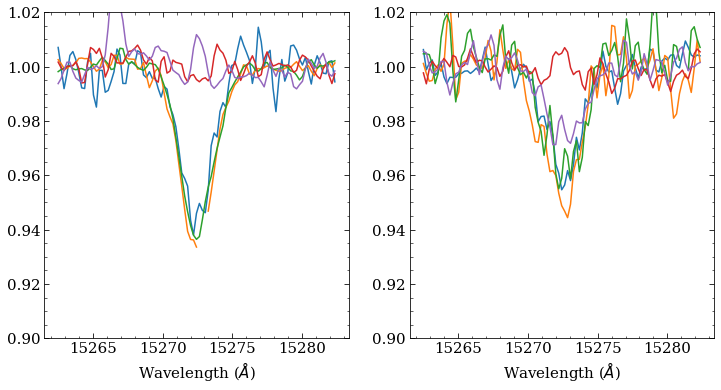

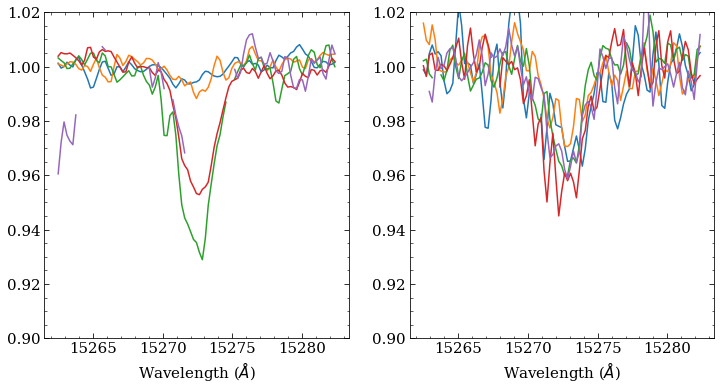

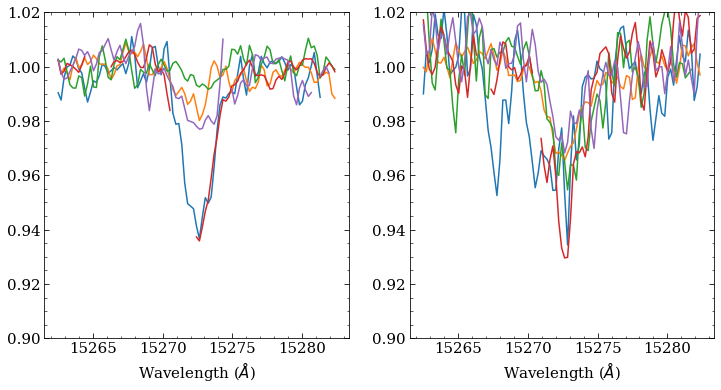

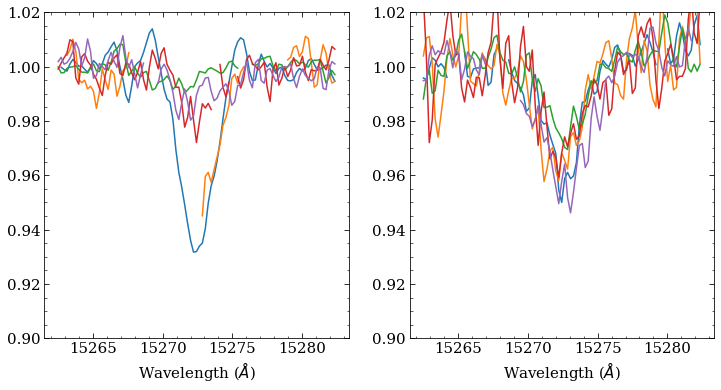

In [19]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    ax = axs[0]
    for j in range(len(sl.signals)):
        ax.plot(wavs_window, sl.signals[j, :])
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')
    ax = axs[1]
    for j in range(len(sl.actual_DIBs)):
        ax.plot(wavs_window, sl.actual_DIBs[j, :])
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')
    plt.show()

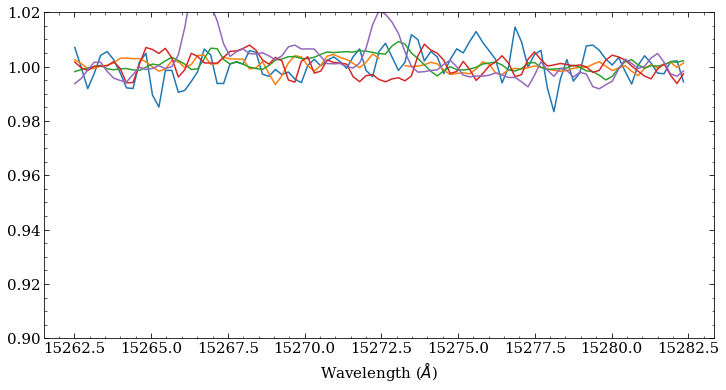

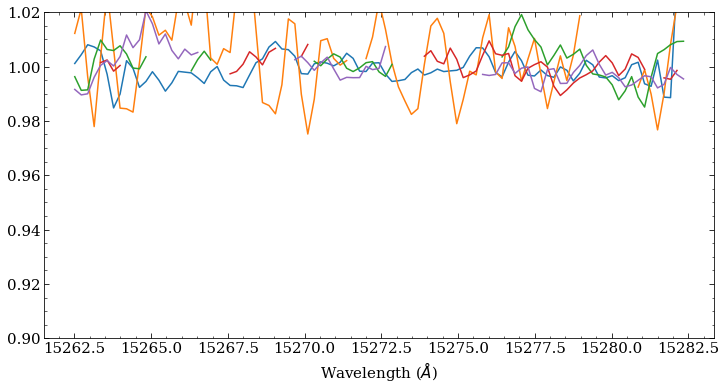

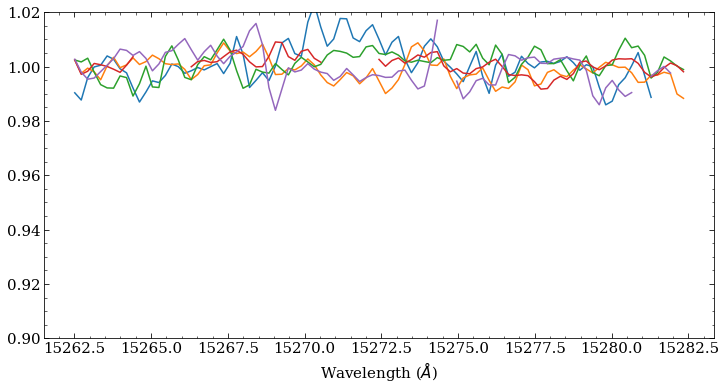

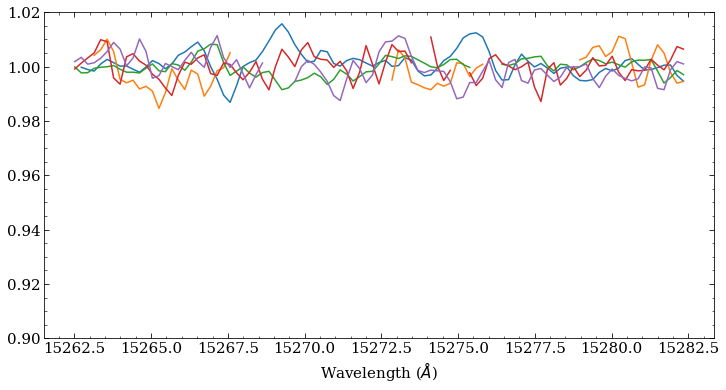

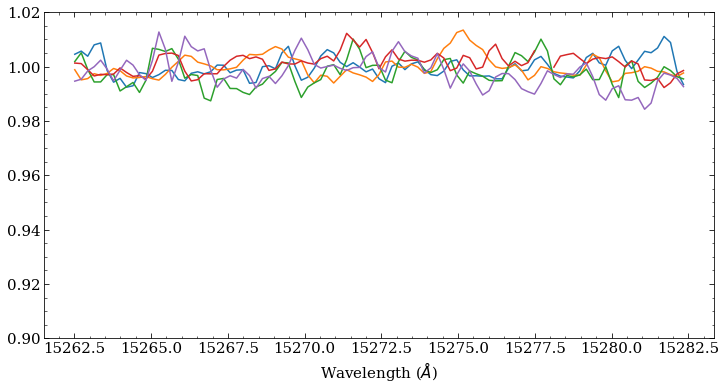

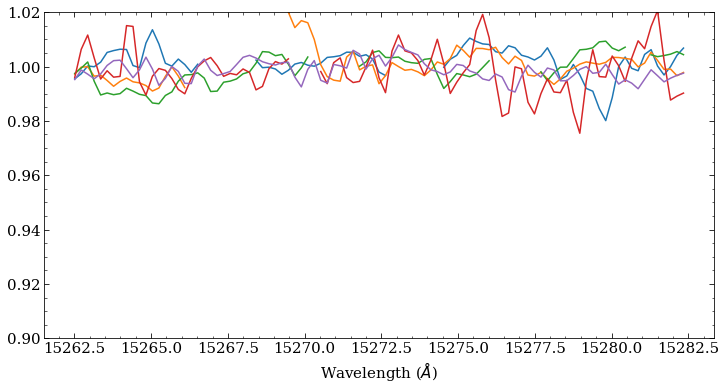

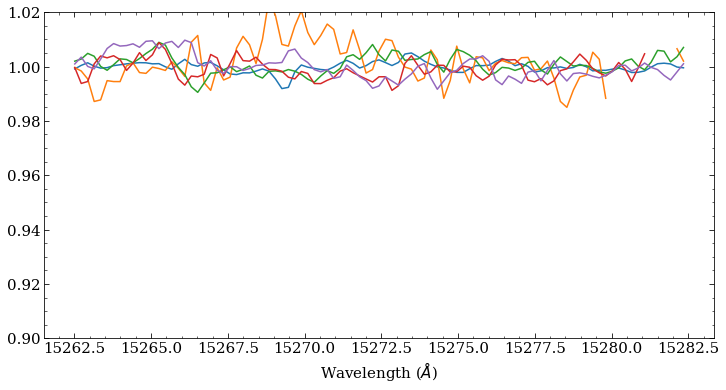

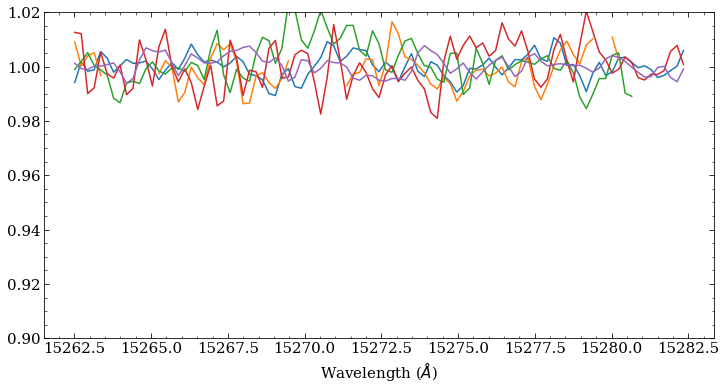

In [20]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
    for j in range(len(sl.signals)):
        ax.plot(wavs_window, sl.signals[j, :] - sl.raw_DIB[j, :] + 1 )
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')

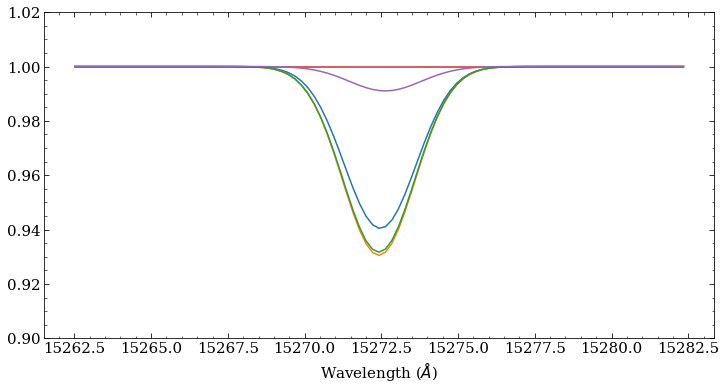

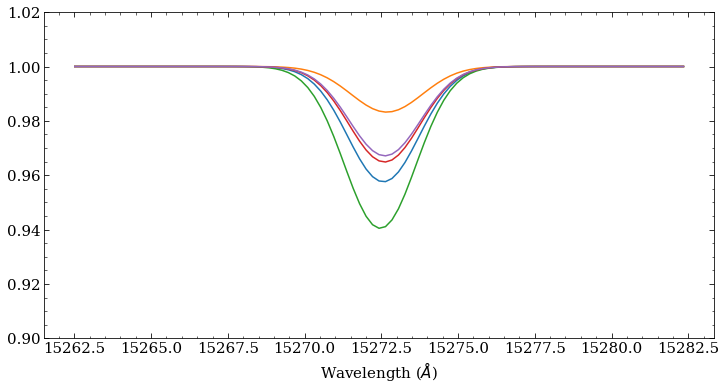

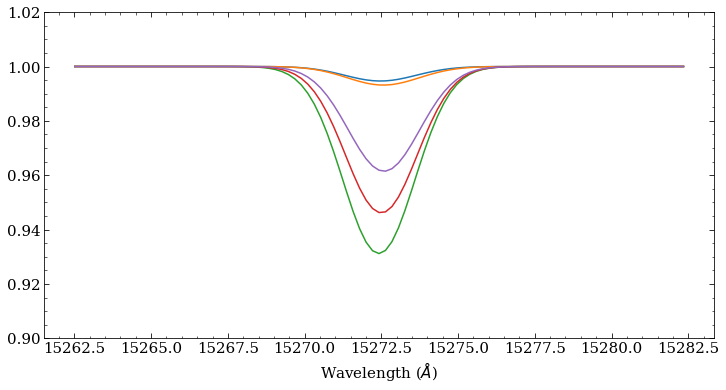

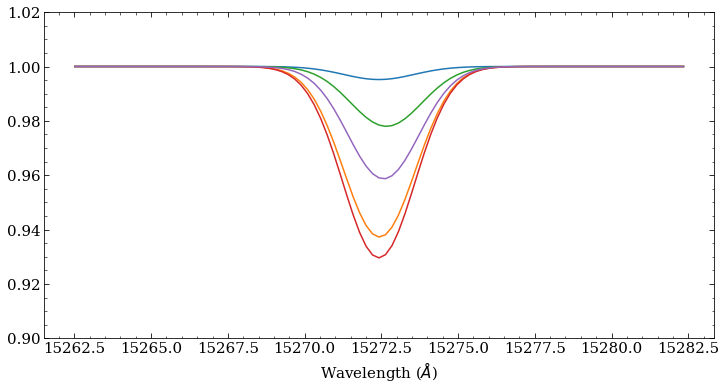

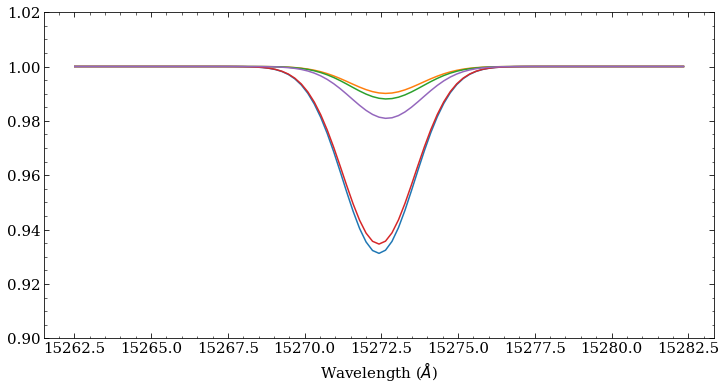

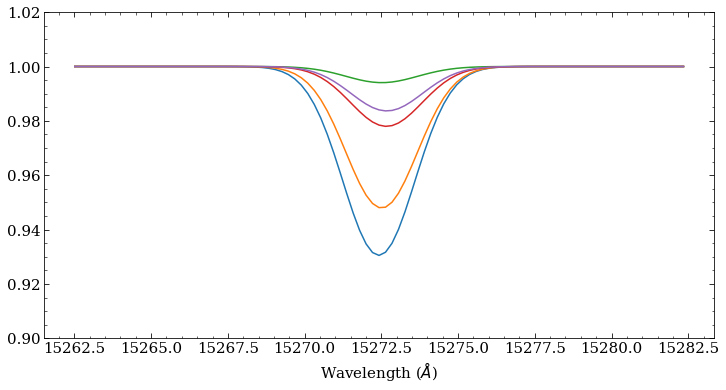

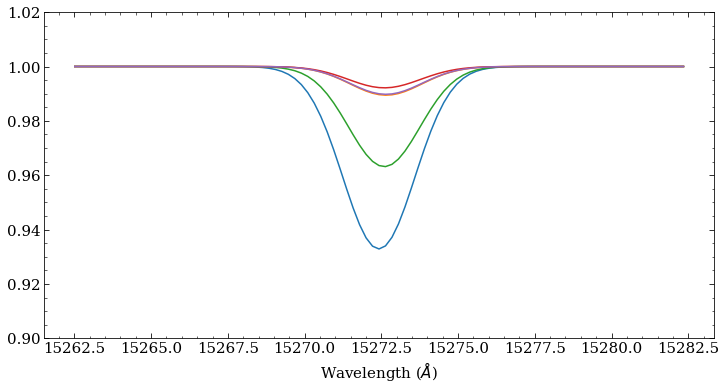

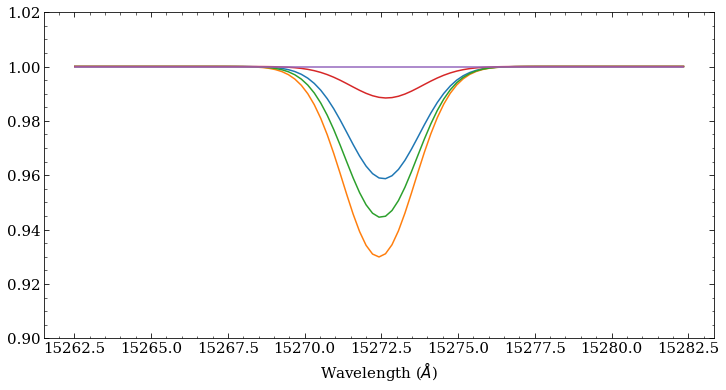

In [21]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
    for j in range(len(sl.signals)):
        ax.plot(wavs_window, sl.raw_DIB[j, :] )
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')

In [22]:
sl.raw_DIB.shape

(5, 95)

In [23]:
from MCMCfns import logprob_2

In [24]:
farvelo

-10

In [25]:
def logprior_v_mod(v, vmin = 1.2 * farvelo, vmax = 1.2 * nearvelo, **kwargs):
    if np.any(v > vmax) or np.any(v < vmin):
        return - np.inf
    return 0.0

In [26]:
def MCMC_scary_mod(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl, 'logprior': logprior_v_mod, 'prior_mult':  1, 'v_max': 20, 'sigma': None}, pool = pool)
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 * (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

In [27]:
stp = 1500
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

# INJECTIONTEST_0214b: v 10 to -10. expanded prior.
# INJECTIONTEST_0214c: v 50 to -50. 
# INJECTIONTEST_0215a: v 50 to -50. 
# INJECTIONTEST_0216a: v 50 to -50. This time, use gaussian profile for all dAVdd 
# INJECTIONTEST_0216b: v 50 to -50. This time, use gaussian profile for all dAVdd and non-injection continua (Gaussian noise)
# INJECTIONTEST_0220a: v 10 to -10, otherwise same as aboves 
# INJECTIONTEST_0222a: v 10 to -10, real dAVdd, Gaussian noise
# INJECTIONTEST_0222b: v 10 to -10, real dAVdd, real residuals, 
# INJECTIONTEST_0227a: v 10 to -10, gaussian dAVdd, real residuals.
# note: all above since 2014c had prior expanded to +/- 50 km/s, regardless of velocities. From now on, prior limited to 1.2 * nearvelo, farvelo
# INJECTIONTEST_0227b: v 10 to -10, gaussian dAVdd, real residuals, updated prior as listed above




run_label = 'INJECTIONTEST_0227b'
save_individual = False

first_run = False



if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS/' + run_label)
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            try:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_scary_mod(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                sl_i.intake(smplr)
                state = 'success'
            except Exception as e:
                print('Something went wrong')
                sl_i = None 
                state = 'fail'
                with open('RUNS/' + run_label + '/FAILS.txt', mode = 'a') as fails:
                    fails.write(str(e))
                
            with open('RUNS/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)

# sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:12<00:00,  7.81it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:06<00:00,  8.04it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:05<00:00,  8.08it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:10<00:00,  7.88it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:11<00:00,  7.83it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:09<00:00,  7.91it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:08<00:00,  7.95it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:12<00:00,  7.79it/s]


NDIM: 4 NSTAR: 5 INITSHAPE: (500, 24)


100%|██████████| 1500/1500 [03:12<00:00,  7.77it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1500/1500 [03:13<00:00,  7.76it/s]


In [28]:
name = run_label

# first_run = True

if first_run:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()
else:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

    sightlines = pickle.load(f)
    f.close()

(100000, 5)


(100000, 5)


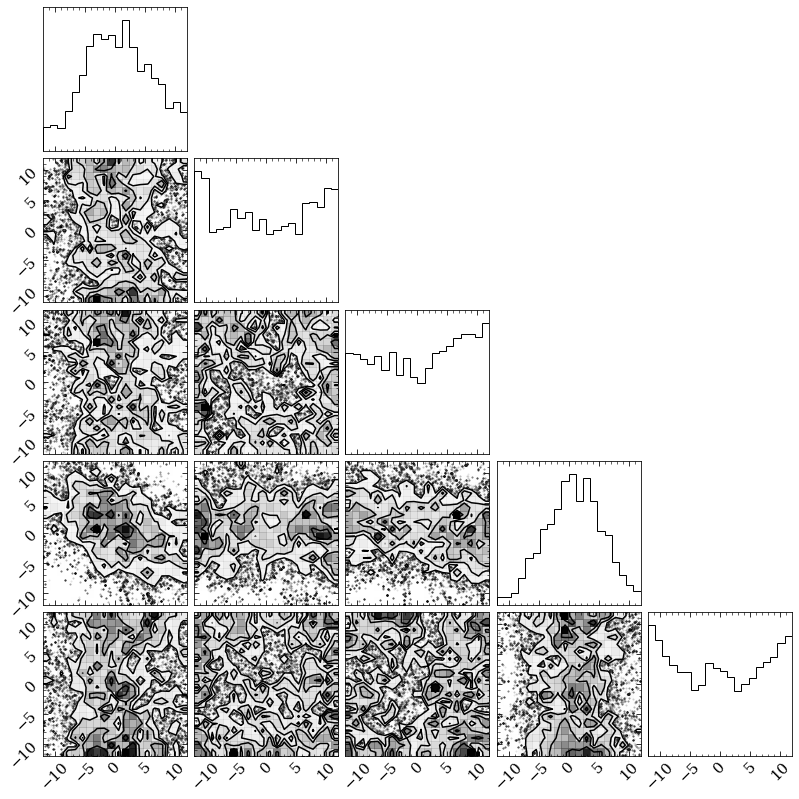

(100000, 4)


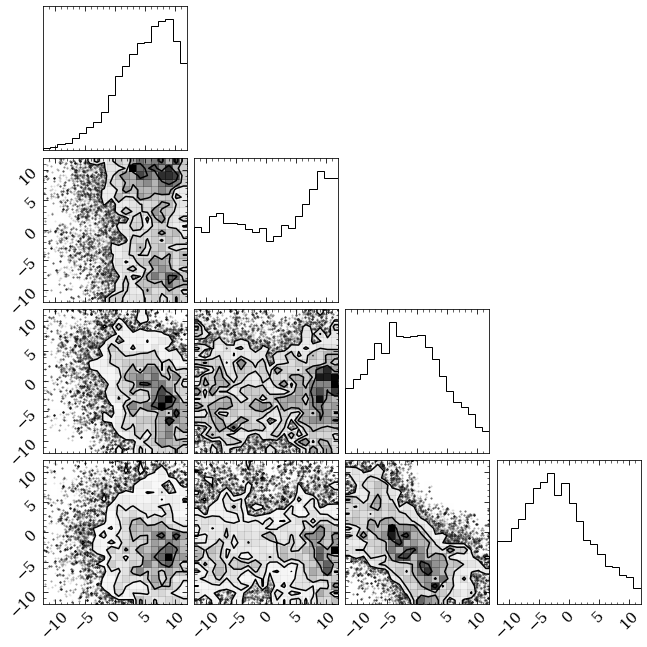

In [29]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if True:
    for i in range(0, len(sightlines), 4):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 0
(5, 95) (5, 5, 95) (5, 5)


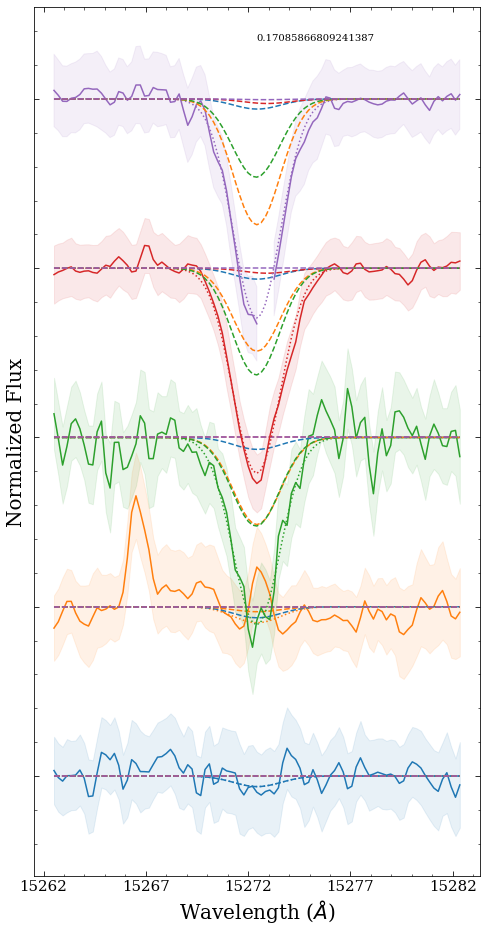

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 1
(5, 95) (5, 5, 95) (5, 5)


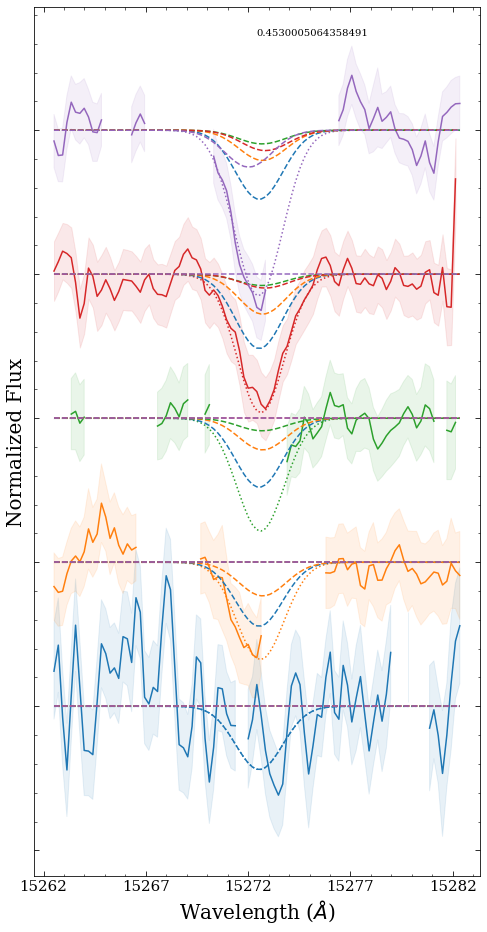

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 2
(5, 95) (5, 5, 95) (5, 5)


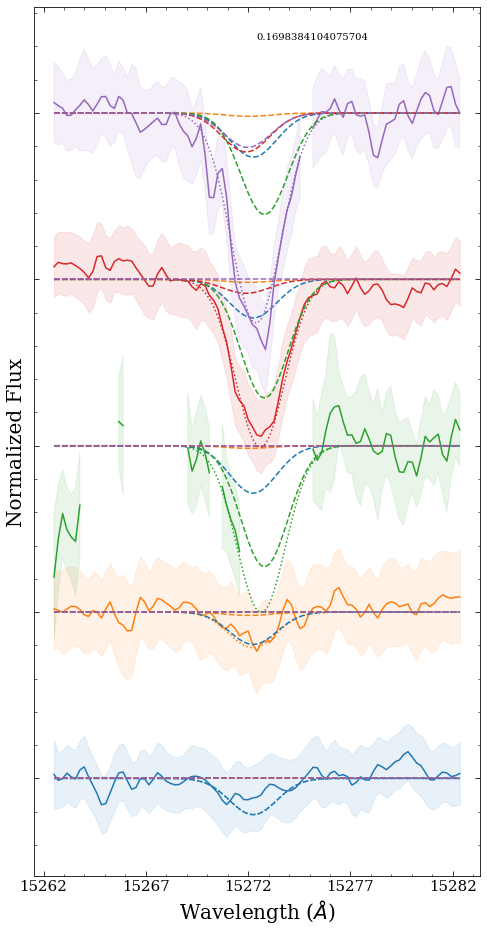

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 3
(5, 95) (5, 5, 95) (5, 5)


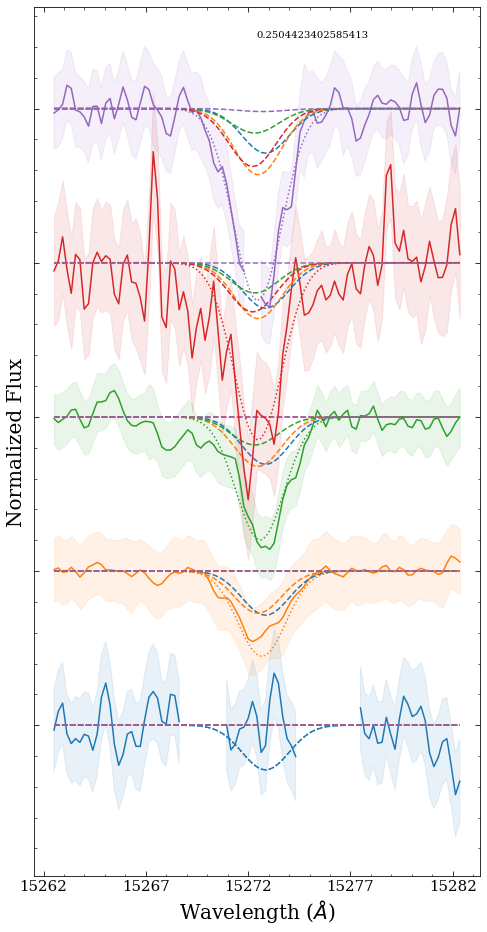

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 4
(5, 95) (5, 5, 95) (5, 5)


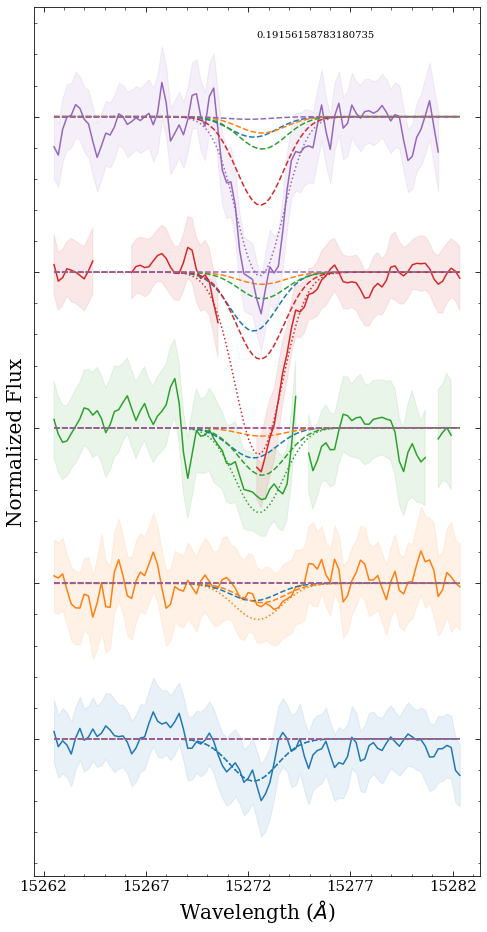

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 5
(5, 95) (5, 5, 95) (5, 5)


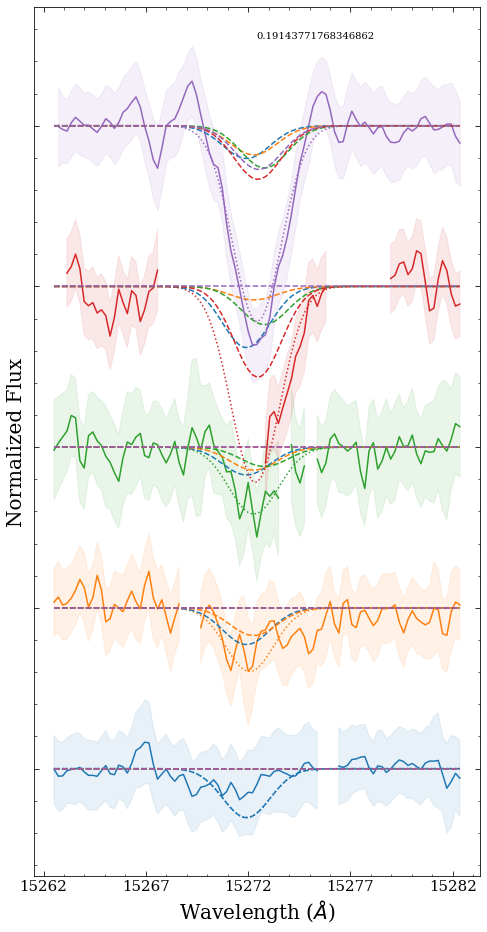

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 6
(5, 95) (5, 5, 95) (5, 5)


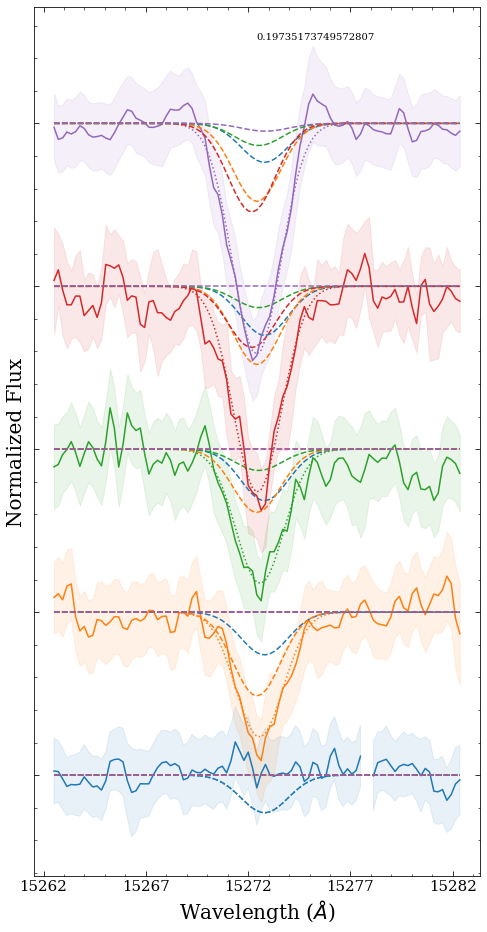

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 7
(5, 95) (5, 5, 95) (5, 5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 8
(5, 95) (5, 4, 95) (5, 4)


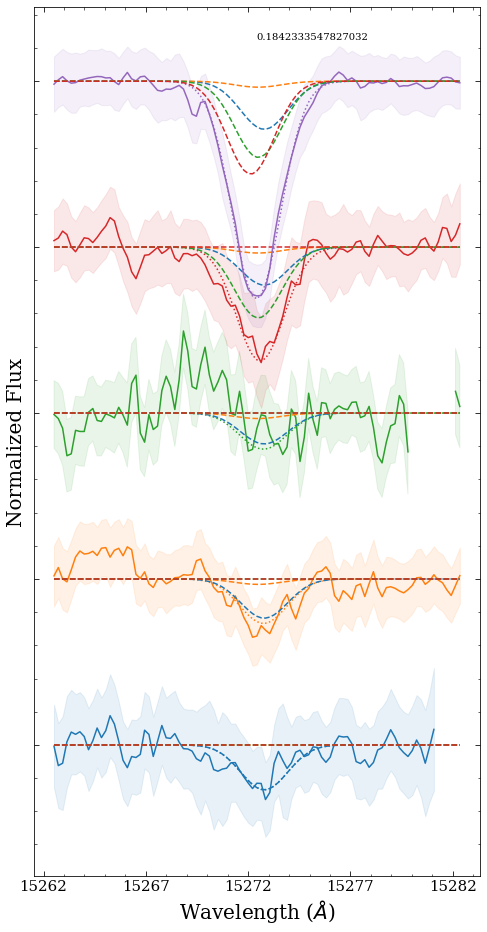

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 9
(5, 95) (5, 5, 95) (5, 5)


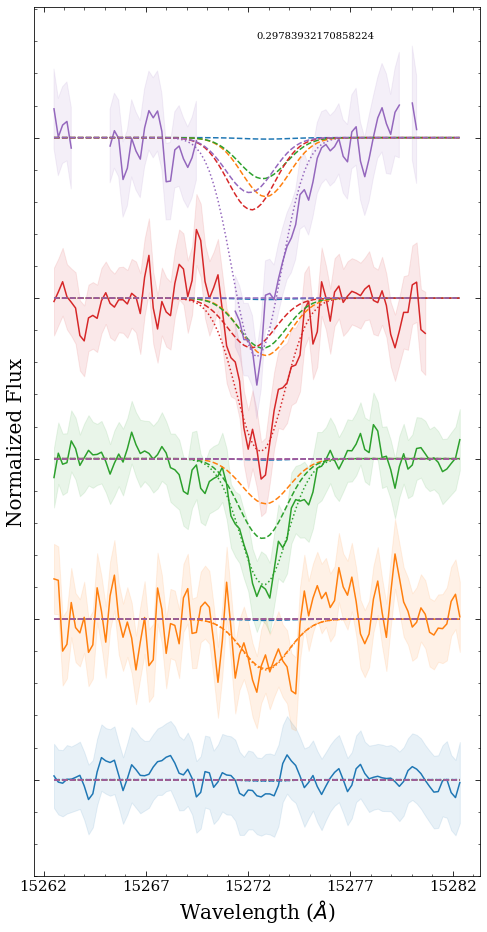

In [30]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = differentialAmplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        bindex = sl.bin_index[ii]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 4))

    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 8))
    ax.set_yticklabels('')

def plot_DIBS_logprob(sampler, sl, plot_objs = None, bestprob = True):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)

    ## NEW THING
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_logprob(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs)==False)
    chi2s[i] = chi2

    ymin, ymax = ax.get_ylim()
    ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/231015_DIBmodels/{}.png'.format(name_i), overwrite = True)

    plt.show()




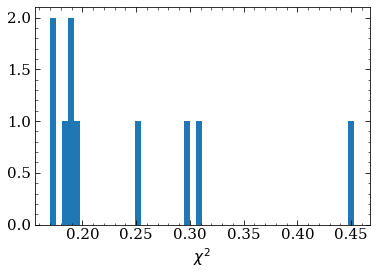

In [31]:
fig, ax = plt.subplots()
ax.hist(chi2s, bins = 50)
ax.set_xlabel('$\chi^2$')
plt.show()

In [32]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])
    sl_davdd[i, :] = diff_AV

In [33]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    # vel_samples = sampler.chain[:, min_walker_val, :].reshape((-1, sl.ndim))
    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

        if plot_violin:
            
            pos = (sl.bins[1:] + sl.bins[:-1])/2
            w = (sl.bins[1:] - sl.bins[:-1])
            ax.violinplot(vel_samples, pos, widths = w, showmeans=True, showextrema=False, showmedians=True)



    else:  
        # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
        ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
        if plot_lines:
            ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


N  0
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 0.51935376  0.14290222 -0.72080531  9.87712717  7.9884455 ]
[472.06390381 547.76434326 577.60766602]
(array([  0.09883141, -47.10727498]), array([[ 1.18828365e-03, -6.04437250e-01],
       [-6.04437250e-01,  3.09920120e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


N  1
[219.78427124 455.03808594 475.51266479 485.52267456 507.90985107]
[ 2.36989623  5.66820939  5.10316266  8.20250915 -7.76443158]
[455.03808594 475.51266479 485.52267456 507.90985107]
(array([ -0.2475072 , 121.74362005]), array([[ 2.36591469e-02, -1.13929247e+01],
       [-1.13929247e+01,  5.49486089e+03]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


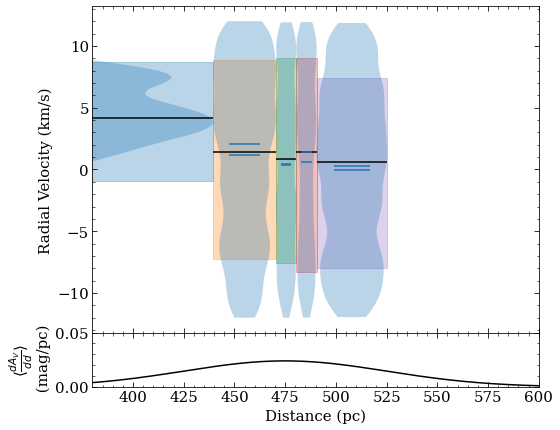

N  2
[201.79954529 408.60409546 446.96191406 495.33456421 543.1262207 ]
[ -3.40042648  -7.66886113   7.43944335 -10.22824063  -8.7407888 ]
[408.60409546 446.96191406 495.33456421 543.1262207 ]
(array([-0.07647353, 34.01339471]), array([[ 1.32903402e-02, -6.19231379e+00],
       [-6.19231379e+00,  2.91226568e+03]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


N  3
[200.25393677 425.71636963 468.37747192 511.1282959  589.63739014]
[ 8.50991062  1.22308747 -1.73590739 -3.85842318  5.43245875]
[425.71636963 468.37747192 511.1282959  589.63739014]
(array([  0.02455739, -12.41384512]), array([[ 1.53017016e-03, -7.61103725e-01],
       [-7.61103725e-01,  3.83565298e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


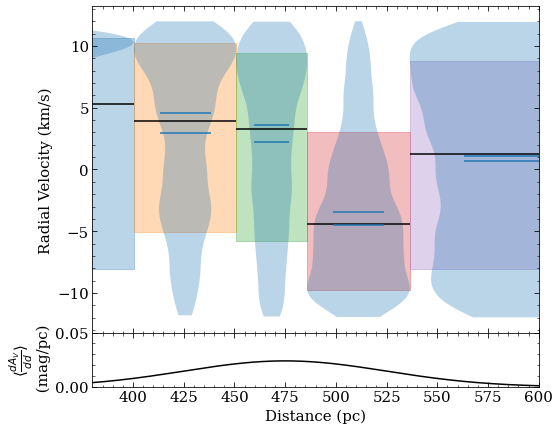

N  4
[210.72927856 426.46356201 437.93457031 496.68527222 561.67285156]
[-2.94859765  4.95505722  5.26759015  3.38265354 -7.85431819]
[426.46356201 437.93457031 496.68527222 561.67285156]
(array([-0.08630276, 43.88869898]), array([[ 1.26601842e-03, -6.12404245e-01],
       [-6.12404245e-01,  2.98874955e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


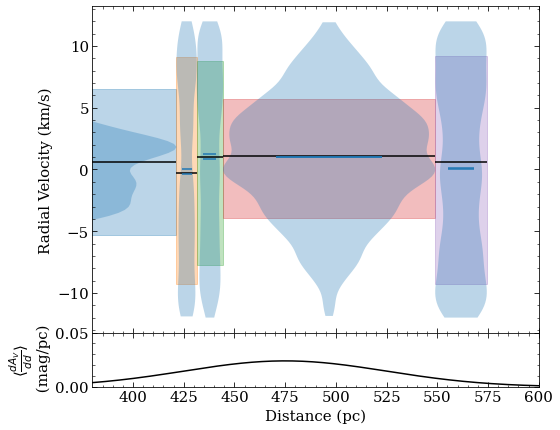

N  5
[203.15335083 422.27020264 444.5123291  478.56817627 546.32177734]
[-9.81779862 -2.85225947  7.5144314   1.13746783  1.97117045]
[422.27020264 444.5123291  478.56817627 546.32177734]
(array([ 0.00527676, -0.44143094]), array([[ 2.81808805e-03, -1.34449839e+00],
       [-1.34449839e+00,  6.47720633e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


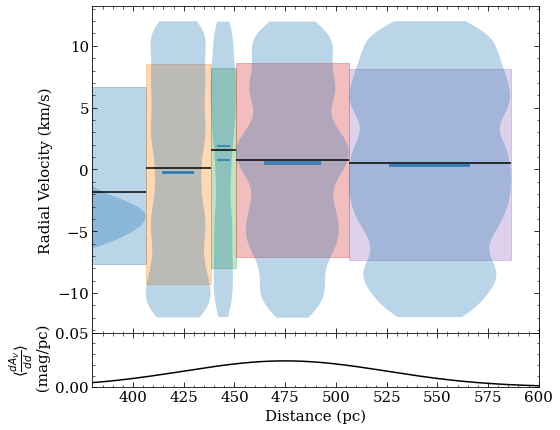

N  6
[194.556427   436.07519531 488.04251099 519.3347168  557.64611816]
[ 7.52139799  0.16116247  1.85502925 -4.78584878  8.118342  ]
[436.07519531 488.04251099 519.3347168  557.64611816]
(array([  0.02215398, -10.82852924]), array([[ 4.85922711e-03, -2.40581979e+00],
       [-2.40581979e+00,  1.20064247e+03]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


N  7
[206.06762695 453.89193726 500.65362549 515.43652344 558.07305908]
[3.11813703 3.26979038 2.14311225 0.21539693 9.44295929]
[453.89193726 500.65362549 515.43652344 558.07305908]
(array([  0.03158588, -11.71379124]), array([[ 1.74226625e-03, -8.40437680e-01],
       [-8.40437680e-01,  4.07926878e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


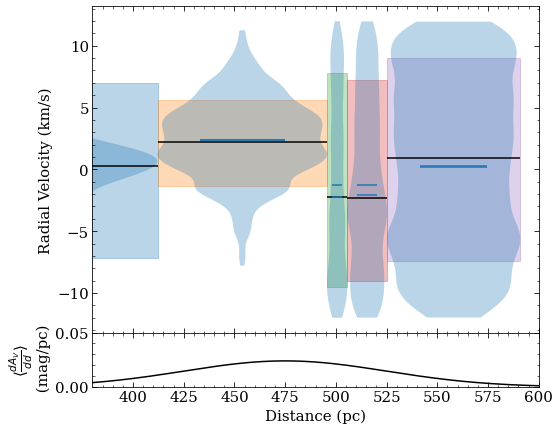

N  8
[207.2645874  419.53417969 451.1105957  518.91821289]
[ 7.188342    1.24092043  1.52676414 -5.77809122]
[419.53417969 451.1105957  518.91821289]
(array([-0.08201347, 37.2200263 ]), array([[ 8.09689072e-04, -3.80108342e-01],
       [-3.80108342e-01,  1.79749823e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


N  9
[ 62.57159424 275.65478516 456.00408936 500.40039062 559.28851318]
[ 9.4686508   8.5321723   5.77165408 -4.94278983 -6.75125727]
[456.00408936 500.40039062 559.28851318]
(array([-0.12677339, 62.32964458]), array([[ 3.18467497e-03, -1.57241844e+00],
       [-1.57241844e+00,  7.81972479e+02]]))


/tmp/ipykernel_3558900/3036378297.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


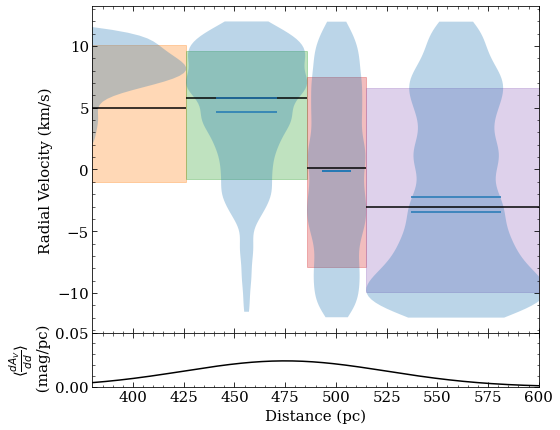

In [34]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])


for i in range(len(sightlines)): 
    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, plot_box = True, plot_violin=True, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] >= 380) & (dist_xx[dist_sort] <= 600)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ax.plot(sl.stars['DIST'], )
    # axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
    #                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

    # ymin, ymax = ax.get_ylim()
    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(380, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    name_i = 'veldist_' + str(i)
    fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

In [35]:
from scipy.stats import spearmanr 

In [36]:
def gradientmetric_deriv(array, dist):    
    a, b = np.meshgrid(array, array)
    c, d = np.meshgrid(dist, dist)
    grad_matrix = np.triu(b - a)
    deltadist = np.triu(d - c)
    nz = grad_matrix != 0
    grad_matrix[nz] = grad_matrix[nz] / deltadist[nz]
    shape = grad_matrix.shape[0]
    return np.sum(grad_matrix) / (0.5 * shape * (shape - 1))

sl_metrics = np.zeros(len(sightlines))
sl_spearman = np.zeros((len(sightlines), 2))

v_all = np.array([], dtype = float)
verr_all = np.array([], dtype = float)
d_all = np.array([], dtype = float)
l_sightline = np.array([], dtype = float)
sl_counts = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    ndim = len(sl_i.voxel_dAVdd)
    walker_max = sl_i.sampler.chain.shape[1]
    min_walker_val = walker_max - 100
    sampler = sl_i.sampler
    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))
    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]
    bin_dist = sl_i.bins[1:]

    metric = np.sum(gradientmetric_deriv(med_velo, bin_dist))
    sl_metrics[i] = metric

    spearman_correlation = spearmanr(bin_dist, med_velo)
    sl_spearman[i, 0] = spearman_correlation.correlation
    sl_spearman[i, 1] = spearman_correlation.pvalue

    v_all = np.concatenate([v_all,med_velo])
    verr_all = np.concatenate([verr_all, std_velo]) 
    d_all = np.concatenate([d_all, bin_dist])

    l_sightline = np.concatenate([l_sightline, l_sample[i] * np.ones(len(med_velo))])
    sl_counts[i] = len(med_velo)

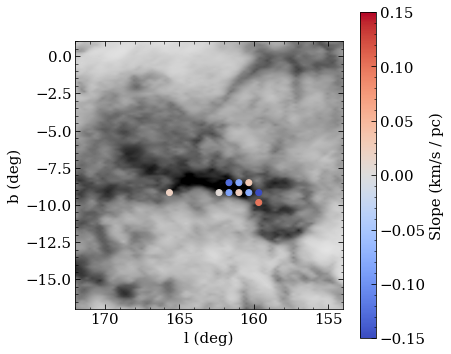

In [37]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sightlines_slopes[:len(sightlines)], vmin = -0.15, vmax = 0.15, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Slope (km/s / pc)')
plt.show()



In [38]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_metrics[:len(sightlines)], vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Metric')
plt.show()


In [39]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:len(sightlines), 0], s= 100 * (1-sl_spearman[:len(sightlines), 1]), vmin = -1, vmax = 1, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()


In [40]:
all_dAVdd = np.zeros((len(sightlines), len(dust_data.distance)))
for i in range(len(sightlines)):
    sl = sightlines[i]
    dustcolumn_array = sl.dustcolumn
    all_dAVdd[i, :] = np.nanmedian(dustcolumn_array, axis = 0)
med_dAVdd = np.nanmedian(all_dAVdd, axis = 0)


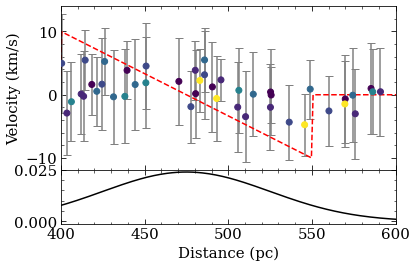

In [41]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': (3,1)})
ax = axs[0]
fil = np.nansum(crit_filament)
fil_idx = np.sum(sl_counts[:fil]).astype(int)
start = 0
stop = None
ax.errorbar(d_all[start:stop], v_all[start:stop], yerr = verr_all[start:stop], fmt = '.', capsize = 4, color = 'grey')

points = ax.scatter(d_all[start:stop], v_all[start:stop], c = l_sightline[start:stop], zorder = 5, )

ax.plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dashed')

ax.set_xlim(400, 600)
ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')

ax = axs[1]
ax.plot(dust_data.distance, np.nanmedian(sl_davdd, axis = 0), color = 'k')
ax.set_xlabel('Distance (pc)')
ax.set_xlim(400, 600)



plt.show()

In [42]:
dist_restrict = (d_all > 400) & (d_all < 550 )
all_spearman = spearmanr(d_all, v_all)
print('ALL:', all_spearman)

restr_spearman = spearmanr(d_all[dist_restrict], v_all[dist_restrict])
print('extent of cloud:', restr_spearman)

ALL: SpearmanrResult(correlation=-0.33755102040816315, pvalue=0.017694914643955357)
extent of cloud: SpearmanrResult(correlation=-0.28803088803088805, pvalue=0.08847295559584702)


In [43]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': (3,1)})
ax = axs[0]
fil = np.nansum(crit_filament)
fil_idx = np.sum(sl_counts[:fil]).astype(int)
start = 0
stop = None
ax.errorbar(d_all[start:stop], v_all[start:stop], yerr = verr_all[start:stop], fmt = '.', capsize = 4, color = 'grey')

points = ax.scatter(d_all[start:stop], v_all[start:stop], c = l_sightline[start:stop], zorder = 5, )

ax.plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dashed')

ax.set_xlim(400, 600)
ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')

ax = axs[1]
ax.plot(dust_data.distance, np.nanmedian(sl_davdd, axis = 0), color = 'k')
ax.set_xlabel('Distance (pc)')
ax.set_xlim(350, 600)



plt.show()

In [44]:
np.savetxt('spearman' + run_label + '.csv', sl_spearman.astype(float), )